In [1]:
# %load withholding.py
%matplotlib notebook
import matplotlib as plt
import numpy as np
import pandas as pd

df = pd.read_csv("../../data/withholding.tsv", sep="\t")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

def parse_array(s):
    try:
        return np.fromstring(s, dtype=float, sep="|")
    except:
        return np.array([float('nan')])

def expand(row):
    compute = parse_array(row.compute)
    rcompute = compute / np.sum(compute)
    activations = parse_array(row.activations)
    assert(np.sum(activations) == row.number_activations or row.error)
    ractivations = activations / row.number_activations
    reward = parse_array(row.reward)
    rreward = reward / np.sum(reward)
    d = {}
    d['attacker_compute'] = rcompute[0]
    d['attacker_relative_activations'] = ractivations[0]
    d['attacker_relative_reward'] = rreward[0]
    d['attacker_gain'] = rreward[0] - ractivations[0]
    d['attacker_efficiency'] = rreward[0] / ractivations[0]
    return d

df=df.join(df.apply(expand, axis=1, result_type='expand'))

In [2]:
df.columns

Index(['network', 'network_description', 'compute', 'protocol', 'k',
       'protocol_description', 'block_interval', 'activation_delay',
       'number_activations', 'activations', 'incentive_scheme',
       'incentive_scheme_description', 'scenario', 'scenario_description',
       'strategy', 'strategy_description', 'reward', 'machine_duration_s',
       'error', 'attacker_compute', 'attacker_relative_activations',
       'attacker_relative_reward', 'attacker_gain', 'attacker_efficiency'],
      dtype='object')

In [3]:
df.pivot(index=['attacker_compute', 'k'], columns=['protocol', 'strategy', 'incentive_scheme'], values='attacker_gain')

protocol                        bk+ll                                     \
strategy             selfish-advanced           selfish-simple             
incentive_scheme             constant     block       constant     block   
attacker_compute k                                                         
0.1              1          -0.099981 -0.099981       0.000000  0.000000   
                 2          -0.076461 -0.078419      -0.036089  0.009081   
                 4          -0.083405 -0.073991      -0.052866  0.026695   
                 8          -0.085543 -0.063350      -0.058914  0.062023   
                 16         -0.084200 -0.038635      -0.058746  0.123492   
...                               ...       ...            ...       ...   
0.5              8           0.357887  0.456693       0.035012  0.433204   
                 16          0.435658  0.499552       0.028834  0.493293   
                 32          0.470000  0.499561       0.015441  0.499818   
                 64          0.482602  0.500481       0.007855  0.499945   
                 128         0.491954  0.499945       0.003926  0.498951   

protocol                                        bk                             \
strategy                honest              honest           selfish-advanced   
incentive_scheme      constant     block  constant     block         constant   
attacker_compute k                                                              
0.1              1    0.000000  0.000000  0.000000  0.000000        -0.033326   
                 2    0.000000 -0.000043  0.000000  0.000487        -0.052551   
                 4    0.000000  0.000123  0.000000  0.000079        -0.065897   
                 8    0.000000  0.000803  0.000000 -0.000333        -0.073753   
                 16   0.000000  0.000131  0.000000 -0.001277        -0.077000   
...                        ...       ...       ...       ...              ...   
0.5              8    0.000000 -0.001296  0.000000  0.000398         0.382245   
                 16   0.000000 -0.000720  0.000000 -0.000513         0.441317   
                 32   0.000000 -0.003476  0.000000 -0.001231         0.469644   
                 64   0.000000 -0.002452  0.000000  0.002922         0.485334   
                 128 -0.000007 -0.006848  0.000004  0.003637         0.493032   

protocol                                                           \
strategy                       numeric-selfish-advanced             
incentive_scheme         block                 constant     block   
attacker_compute k                                                  
0.1              1   -0.033326                -0.033326 -0.033326   
                 2   -0.024006                -0.052551 -0.024006   
                 4   -0.011502                -0.065897 -0.011502   
                 8    0.001347                -0.073753  0.001347   
                 16   0.019401                -0.077000  0.019401   
...                        ...                      ...       ...   
0.5              8    0.472974                 0.381945  0.472600   
                 16   0.499431                 0.441063  0.499835   
                 32   0.500037                 0.470397  0.499745   
                 64   0.499696                 0.484954  0.499771   
                 128  0.499541                 0.492046  0.499755   

protocol                                       
strategy             numeric-honest            
incentive_scheme           constant     block  
attacker_compute k                             
0.1              1         0.000000  0.000000  
                 2         0.000000  0.000487  
                 4         0.000000  0.000079  
                 8         0.000000 -0.000333  
                 16        0.000000 -0.000812  
...                             ...       ...  
0.5              8         0.000000 -0.002321  
                 16        0.000000 -0.002139  
                 32        0.00

<IPython.core.display.Javascript object>


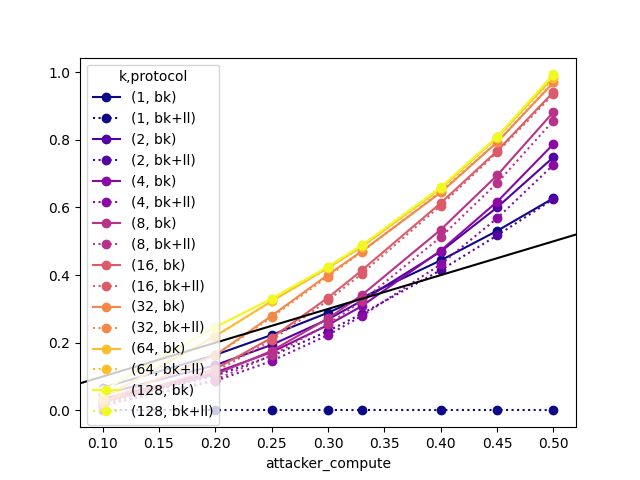

In [18]:
# compare same strategy for different protocols
d = df
d = d[d['strategy']=='selfish-advanced']
d = d[d['incentive_scheme']=='constant']
d = d.pivot(index=['attacker_compute'], columns=['k', 'protocol'], values='attacker_relative_reward')
d = d[sorted(d.columns)]
line_style = [ 'o-' if proto == 'bk' else 'o:' for (k, proto) in  d.columns]
k = np.unique([ k for (k, proto) in d.columns])
cmap = plt.cm.get_cmap('plasma', len(k))
colormap = { k: cmap(i) for (i, k) in enumerate(k) }
line_colors = [ colormap[k] for (k, proto) in d.columns ]
line_colors
p = d.plot(style=line_style, color=line_colors)
p.axline([.1, .1], [.5, .5], color='black')

<IPython.core.display.Javascript object>


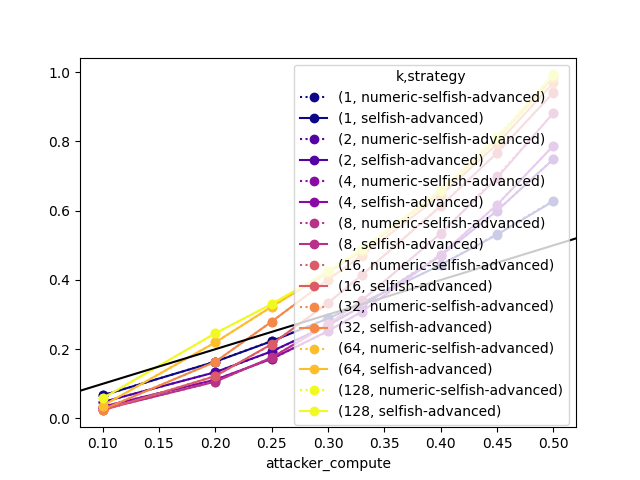

In [16]:
# does numerical implementation line up with non-numerical implementation of policiy?
d = df
d = d[d['protocol']=='bk']
d = d[(d['strategy']=='selfish-advanced') | (d['strategy']=='numeric-selfish-advanced')]
d = d[d['incentive_scheme']=='constant']
d = d.pivot(index=['attacker_compute'], columns=['k', 'strategy'], values='attacker_relative_reward')
d = d[sorted(d.columns)]
line_style = [ 'o-' if proto == 'selfish-advanced' else 'o:' for (k, proto) in  d.columns]
k = np.unique([ k for (k, proto) in d.columns])
cmap = plt.cm.get_cmap('plasma', len(k))
colormap = { k: cmap(i) for (i, k) in enumerate(k) }
line_colors = [ colormap[k] for (k, proto) in d.columns ]
line_colors
p = d.plot(style=line_style, color=line_colors)
p.axline([.1, .1], [.5, .5], color='black')
# yes it does!